In [148]:
import os, sys
import yaml
import itertools
from collections import defaultdict
from pathlib import Path
# from src.runner import Runner
# from src.eval import Eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
print("seaborn version: " + sns.__version__)

seaborn version: 0.9.0


In [2]:
def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

In [3]:
base_dir = "/data/jeff-law/projects/2019-04-single-cell/RNMethods"
os.chdir(base_dir)

In [4]:
def summarize(s, cutoff=0, less_than=False):
    print('\t'.join(['median','MAD','cutoff','perc']))
    if less_than:
        perc_pass_cutoff = len(s[s <= cutoff]) / float(len(s))*100
    else:
        perc_pass_cutoff = len(s[s >= cutoff]) / float(len(s))*100
    print("%0.2f\t%0.2f\t%0.2f\t%0.1f" % (s.median(), mad(s.values), cutoff, perc_pass_cutoff))

In [5]:
def summary_plt(df, alg, dataset, measure='AUROC'):
    df[measure].plot.hist(bins=20)
    plt.xlabel(measure)
    plt.title("%s - %s" % (alg, dataset))
    plt.show()
    plt.close()

In [39]:
def get_best_params(df, measure, cutoff, params_list, param=None, less_than=False):
    best_params = defaultdict(set)
    params = 'params' if param is None else param
#     params_list = ['l','dT','nl','kw','pz','pr','nr']
    if less_than:
        pass_cutoff = df[df[measure] <= cutoff][params]
    else:
        pass_cutoff = df[df[measure] >= cutoff][params]      
#     print(pass_cutoff)
#     print(df[measure])
#     print(cutoff)
    if param is not None:
        return {param: pass_cutoff.values[0]}
    
    for param in pass_cutoff:
        for i, param_val in enumerate(param.split('-')):
            p = params_list[i]
            val = param_val.replace(p,'')
            best_params[p].add(val)
    print('\t'.join(p for p in params_list))
    print('\t'.join(','.join(best_params[p]) for p in params_list))
    return best_params

In [7]:
def get_param_list(df):
    params_list = []
#     print(df.head())
    for i, param_val in enumerate(df['params'].values[0].split('-')):
        # the parameter name could be multiple letters. Find the first index of a number
        num_idx = min([j for j in range(len(param_val)) if param_val[j].isdigit()])
        p = param_val[:num_idx]
        params_list.append(p)
    return params_list

In [8]:
def get_dataset(eval_file, alg):
    if not os.path.isfile(eval_file):
        print("%s does not exist. Skipping" % (eval_file))
        return None, []
    
    df = pd.read_csv(eval_file, header=0)
    df = df[df['alg'] == alg]
    if len(df) == 0:
        print("No results found for %s in %s. Skipping" % (alg, eval_file))
        return None, []
    
    params_list = get_param_list(df)
#     print("params list: ", params_list)
#     print("%d values" % (len(df)))
    if alg == "SCRIBE":
        p = "delay"
        df[p] = df['params'].apply(lambda x: x.replace(p,''))
    else:
        # expand the parameters into their own columns
        params_df = df['params'].str.split('-', expand=True)
        # df = df.copy()
        for i, col in enumerate(params_df.columns):
            p = params_list[i]
            df[p] = params_df[col].apply(lambda x: float(x.replace(p,'')))

    return df, params_list

In [9]:
def plot_and_get_best_params(df, alg, dataset, measure='AUROC', quantile=0.99):
    # measure = 'AUROC'
    summary_plt(df, alg, dataset, measure=measure)
    cutoff = df[measure].quantile(quantile)
    summarize(df[measure], cutoff)
    best_params = get_best_params(df, measure, cutoff)
    return best_params

In [10]:
def line_plot_and_best_params(df, alg, dataset, param='nBins', measure='AUROC', quantile=0.99):
    df.sort_values(param).plot.line(x=param, y=measure)
#     df.plot.line(x=param, y=measure)
    plt.xlabel(measure)
    plt.title("%s - %s" % (alg, dataset))
    plt.show()
    plt.close()
    
    cutoff = df[measure].quantile(quantile)
    # for some reason, the cutoff is too high sometimes
    cutoff = cutoff - 0.00001
    best_params = get_best_params(df, measure, cutoff, param=param)
    return best_params

In [238]:
def get_results_and_summarize(alg, params, base_datasets, dataset_names, indexes, 
                              in_dir="outputs/simulated/dyn-LI", measure='AUROC', quantile=0.99, postfix=''):
    best_param_list = []
    all_df = pd.DataFrame()
    for base_dataset in base_datasets:
        curr_df = pd.DataFrame()
        num_datasets = 0
        for idx in indexes:
            if idx is not None:
                dataset = "%s-%d" % (dataset_names[base_dataset], idx)
            else:
                dataset = dataset_names[base_dataset]    
            eval_file = "%s/%s/eval%s.csv" % (in_dir, dataset, postfix)
            df, params_list = get_dataset(eval_file, alg)
            if df is None:
                continue
            print("%d values in %s" % (len(df), eval_file))
            num_datasets += 1
        #     print(eval_file)
        #     print(df)
        #     break
#             if params is not None:
#                 df = df[df[param].isin(params)]
            if alg == "SINCERITIES":
                df = df[df[params[0]].apply(int) <= 30]
            if alg == "LEAP":
                df = df[df[params[0]].apply(float) <= 0.4]
#             if alg == "SCODE":
        #         df = df[df['I'] == 1000]
            if len(df.index) == 0:
                print("No values in dataframe")
            curr_df = pd.concat([curr_df, df])
        # and change dyn-LI to Linear
#         curr_df['dataset'] = base_dataset.replace("dyn-LI-", "Linear ")
        curr_df['dataset'] = base_dataset
        all_df = pd.concat([all_df, curr_df])
        print("Taking the median of %d datasets" % (num_datasets))
        print(base_dataset)
        if len(params) == 1:
            param = params[0]
            all_df2 = curr_df.groupby(param).median()
            all_df2.reset_index(inplace=True)
            cutoff = all_df2[measure].quantile(quantile)
            # for some reason, the cutoff is too high sometimes
            cutoff = cutoff - 0.00001
            best_params = get_best_params(all_df2, measure, cutoff, params_list, param=param)
            print(all_df2[all_df2[param] == best_params[param]])
        else:
            all_df2 = curr_df.groupby('params').median()
            cutoff = all_df2[measure].quantile(quantile)
            all_df2.reset_index(inplace=True)
            best_params = get_best_params(all_df2, measure, cutoff, params_list)
        # best_param_list.append(list(best_params[param])[0])
#             print(best_params)
            print("%s cutoff: %s" % (measure, cutoff))
    if alg == 'SCRIBE':
        all_df[param] = pd.Categorical(all_df[param], ["5", "5-10", "5-10-15-20","5-10-15-20-25", "5-10-20-25","5-25-50-75-100", "20-25-50-75-100"])
        all_df.sort_values(param, inplace=True)
    return all_df, best_params
# print(np.histogram(best_param_list))

In [291]:
def summary_plot(all_df, param, measure, title='', out_file=None, rotate=False, ax=None, legend=None):
    curr_ax = sns.lineplot(x=param, y=measure, data=all_df, 
                 hue='dataset', hue_order=base_datasets, style='dataset', markers=True,
                 estimator=np.median, ax=ax,
                           ci=68
#                     ci='sd'
                )
    if legend is not None:
        ax.legend(legend)
    curr_ax.set_title(title)
    if rotate:
        for tick in curr_ax.get_xticklabels():
            tick.set_rotation(-25)
    if out_file is not None:
        print(out_file)
        plt.savefig(out_file)
        plt.show()
        plt.close()

In [293]:
measure = "AUROC"
# UPDATE: maximize the median AUROC across all datasets 
quantile = 0.99
alg_params = {
    "SCRIBE": ['delay'],
    "SCODE": ['D'],
    "SINCERITIES": ['nBins'],
    "LEAP": ['maxLag'],
    "SCINGE": ['l','dT','nl','kw','pz','pr','nr'],
    "GRISLI": ['L','a'],
}
alg_order = ['LEAP', 'SCODE', 'SINCERITIES', 'SCRIBE', 'GRISLI', 'SCINGE']
# alg_order = ['LEAP', 'SCODE', 'SINCERITIES', 'GRISLI', 'SCINGE']
# alg_order = ['SCRIBE']
postfix=''


# for the synthetic datasets:
simulations = "dyn-LI"
data_type = "2019-07-synthetic/dyn-LI"
base_dir = "outputs/%s/" % (data_type)
indexes = range(1,11)
base_datasets = ['dyn-LI-100', 'dyn-LI-200', 'dyn-LI-500', 'dyn-LI-2000', 'dyn-LI-5000']
dataset_names = {
    'dyn-LI-100': 'dyn-LI-100', 
    'dyn-LI-200': 'dyn-LI-200', 
    'dyn-LI-500': 'dyn-LI-500', 
    'dyn-LI-2000': 'dyn-LI-2000', 
    'dyn-LI-5000': 'dyn-LI-5000',
}

# # for the simulated datasets:
# data_type = "simulated/datasets"
# base_dir = "outputs/2019-07-simulated/"
# # base_datasets = ['HSC', 'mCAD', 'VSC']
# base_datasets = ['GSD', 'HSC', 'mCAD', 'VSC']
# dataset_names = {
#     'GSD': 'GSD/GSD-2000',
#     'HSC': 'HSC/HSC-2000',
#     'mCAD': 'mCAD/mCAD-2000',
#     'VSC': 'VSC/VSC-2000',
# }
# indexes = range(1,11)

# # for the real datasets:
# data_type = "datasets"
# base_dir = "outputs/datasets/"
# # base_datasets = ['human/hESC', 'human/hTHP1', 'mouse/mEF', 'mouse/mES-PE', 'mouse/mES-retinoic']
# base_datasets = ['hESC', 'mEF', 'mES-PE']
# dataset_names = {'hESC': 'human/hESC', 'mEF': 'mouse/mEF', 'mES-PE': 'mouse/mES-PE'}
# indexes = [None]
# postfix='-string700'

In [294]:
alg_dfs = {}
for alg in alg_order:
    param = alg_params[alg]
    print("")
    print(alg, param)
    all_df, best_params = get_results_and_summarize(
        alg, param, base_datasets, dataset_names, indexes, measure=measure, quantile=quantile,
        in_dir=base_dir, postfix=postfix
    )
    alg_dfs[alg] = all_df


LEAP ['maxLag']
7 values in outputs/2019-07-synthetic/dyn-LI//dyn-LI-100-1/eval.csv
7 values in outputs/2019-07-synthetic/dyn-LI//dyn-LI-100-2/eval.csv
7 values in outputs/2019-07-synthetic/dyn-LI//dyn-LI-100-3/eval.csv
7 values in outputs/2019-07-synthetic/dyn-LI//dyn-LI-100-4/eval.csv
7 values in outputs/2019-07-synthetic/dyn-LI//dyn-LI-100-5/eval.csv
7 values in outputs/2019-07-synthetic/dyn-LI//dyn-LI-100-6/eval.csv
7 values in outputs/2019-07-synthetic/dyn-LI//dyn-LI-100-7/eval.csv
7 values in outputs/2019-07-synthetic/dyn-LI//dyn-LI-100-8/eval.csv
7 values in outputs/2019-07-synthetic/dyn-LI//dyn-LI-100-9/eval.csv
7 values in outputs/2019-07-synthetic/dyn-LI//dyn-LI-100-10/eval.csv
Taking the median of 10 datasets
dyn-LI-100
   maxLag  num_edges     AUPRC     AUROC     FMAX     ePrec      eRec  \
1     0.1         42  0.700104  0.817347  0.69697  0.545455  0.714286   

     uAUPRC    uAUROC     uFMAX    uePrec     ueRec  
1  0.805271  0.816327  0.759615  0.545455  0.714286  
7 v

In [295]:
# also compute the early precision ratio which is the precision divided by the network density
dataset_density = {}
for dataset in base_datasets:
    true_net_file = "%s/%s%s/refNetwork.csv" % (
        base_dir.replace('outputs','inputs'), dataset_names[dataset], 
        "-%d"%indexes[0] if indexes[0] is not None else "")
#     print(true_net_file)
    true_net_df = pd.read_csv(true_net_file, header=0)
    # drop self edges
    true_net_df = true_net_df[true_net_df['Gene1'] != true_net_df['Gene2']]
    net = true_net_df[['Gene1', 'Gene2']]
    net.columns = ['source', 'target']
    G = nx.DiGraph()
    G = nx.from_pandas_edgelist(net, create_using=G)
#     print(G.number_of_edges())
    dataset_density[dataset] = nx.density(G)
print(dataset_density)

{'dyn-LI-100': 0.16666666666666666, 'dyn-LI-200': 0.16666666666666666, 'dyn-LI-500': 0.16666666666666666, 'dyn-LI-2000': 0.16666666666666666, 'dyn-LI-5000': 0.16666666666666666}


In [296]:
# now add those to the dataframes
for alg, alg_df in alg_dfs.items():
    alg_df['EPR'] = alg_df.apply(lambda x: x['ePrec'] / float(dataset_density[x['dataset']]), axis=1)
    alg_df['AUPRCRatio'] = alg_df.apply(lambda x: x['AUPRC'] / float(dataset_density[x['dataset']]), axis=1)

In [297]:
def overview_plot(alg_params, alg_order, alg_dfs, measure="AUROC", out_file=None):
    # now plot
    f, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,9))
    axes = [axes[0][0], axes[0][1], axes[0][2], axes[1][0], axes[1][1], axes[1][2]]
    # f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    # axes = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
    for i, alg in enumerate(alg_order):
#         if alg != "SCRIBE":
#             continue
        ax = axes[i]
        params = alg_params[alg]
        all_df = alg_dfs[alg]
        if len(params) > 1:
    #         vals = []
            nbins = 10
            if alg == "GRISLI":
                nbins = 5
            for dataset in all_df['dataset'].unique():
    #             vals.append(all_df[all_df['dataset'] == dataset][measure])
                sns.distplot(all_df[all_df['dataset'] == dataset].groupby('params').median()[measure], ax=ax, kde=False, label=dataset, bins=nbins)
    #         ax.hist(vals, label=all_df['dataset'].unique())
            ax.set_ylabel('Frequency')
            ax.set_title(alg)
            ax.legend()
            if measure == "AUPRC":
                ax.set_xlim(0,1.0)
            elif measure == "EPR":
                ax.set_xlim(1.0, 2.1)
            elif measure == "AUPRCRatio":
                ax.set_xlim(0.8, 1.8)
        else:
            param = params[0]
            summary_plot(all_df, param, measure, title=alg, rotate=True if alg == 'SCRIBE' else False, ax=ax)
            # make sure the y range is not 3 decimal places
            if alg == "SCRIBE":
                from matplotlib.ticker import FormatStrFormatter
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if measure == "AUPRC":
                ax.set_ylim(0,1.0)
            elif measure == "EPR":
                ax.set_ylim(1.0, 2.1)
            elif measure == "AUPRCRatio":
                ax.set_ylim(0.8, 1.8)
        ax.legend(["Linear %d" % (i) for i in (100, 200,500,2000,5000)])

    plt.tight_layout()
    if out_file is not None:
        print(out_file)
        plt.savefig(out_file)
        plt.savefig(out_file.replace('.pdf','.png'))
    plt.show()
    # plt.close()

outputs/viz/2019-07-synthetic/dyn-LI/params//6algs-params-AUPRC.pdf


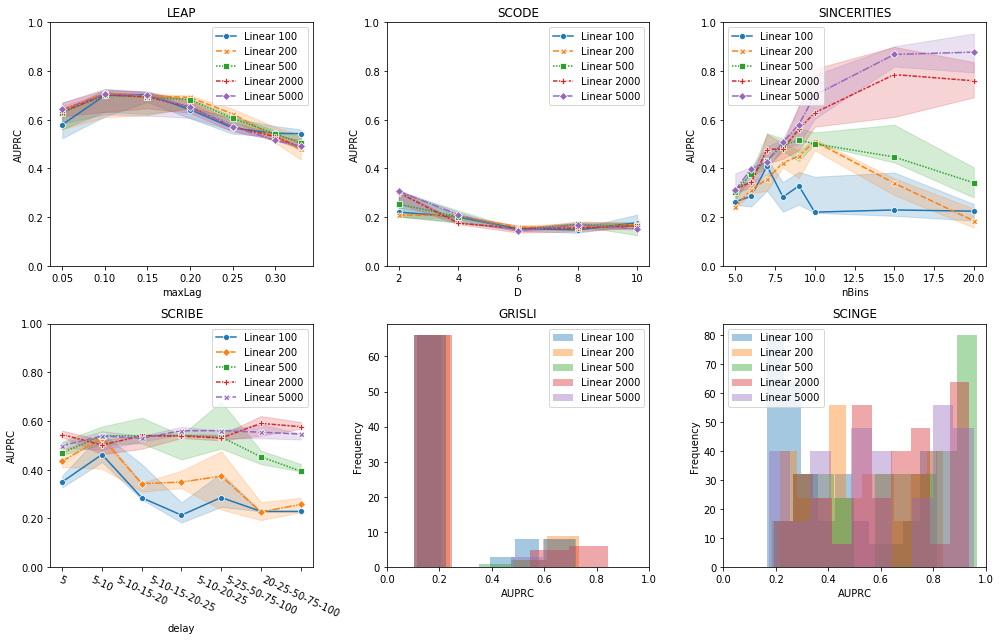

In [298]:
measures = [
#     "AUROC", 
    "AUPRC",
#     "EPR",
#     "AUPRCRatio",
]
out_dir = "outputs/viz/%s/params/" % (data_type)
os.makedirs(out_dir, exist_ok=True)
# alg_df2 = {alg: df for alg, df in alg_dfs.items() if alg != "SCRIBE"} 
# postfix = "-scribe"
for measure in measures:
    out_file = "%s/%dalgs-params-%s%s.pdf" % (out_dir, len(alg_params), measure, postfix)
    overview_plot(alg_params, alg_order, alg_dfs, measure=measure, out_file=out_file)

In [280]:
alg_dfs2 = alg_dfs.copy()
# alg_dfs2['SCRIBE'].dropna(axis=0, how="any", inplace=True)
# alg_dfs2['SCRIBE'] = alg_dfs2['SCRIBE'][alg_dfs2['SCRIBE']['dataset'] != "dyn-LI-100"]
alg_dfs2['SCRIBE'] = alg_dfs2['SCRIBE'][~alg_dfs2['SCRIBE']['delay'].isin(["5-25-50-75-100", "20-25-50-75-100"])]
alg_dfs2['SCRIBE']

,params,alg,num_edges,AUPRC,AUROC,FMAX,ePrec,eRec,uAUPRC,uAUROC,uFMAX,uePrec,ueRec,delay,dataset,EPR,AUPRCRatio
7,delay5,SCRIBE,42,0.436255,0.689796,0.533333,0.428571,0.857143,0.730755,0.816327,0.714286,0.428571,0.857143,5,dyn-LI-100,2.571429,2.617532
13,delay5,SCRIBE,42,0.426179,0.779592,0.545455,0.666667,0.857143,0.827806,0.908163,0.823529,0.666667,0.857143,5,dyn-LI-5000,4.000000,2.557074
7,delay5,SCRIBE,42,0.329534,0.604082,0.370370,0.333333,0.571429,0.556425,0.581633,0.560000,0.333333,0.571429,5,dyn-LI-100,2.000000,1.977205
13,delay5,SCRIBE,42,0.428713,0.787755,0.571429,0.857143,0.857143,0.900425,0.959184,0.933333,0.857143,0.857143,5,dyn-LI-5000,5.142857,2.572278
13,delay5,SCRIBE,42,0.476386,0.722449,0.588235,0.545455,0.857143,0.824785,0.836735,0.800000,0.545455,0.857143,5,dyn-LI-500,3.272727,2.858318
7,delay5,SCRIBE,42,0.374615,0.722449,0.533333,0.461538,0.857143,0.844382,0.826531,0.833333,0.461538,0.857143,5,dyn-LI-100,2.769231,2.247688
13,delay5,SCRIBE,42,0.515915,0.775510,0.500000,0.454545,0.714286,0.788615,0.765306,0.769231,0.454545,0.714286,5,dyn-LI-500,2.727273,3.095488
13,delay5,SCRIBE,42,0.510037,0.693878,0.571429,0.416667,0.714286,0.732806,0.714286,0.727273,0.416667,0.714286,5,dyn-LI-5000,2.500000,3.060222
13,delay5,SCRIBE,42,0.571860,0.759184,0.571429,0.545455,0.857143,0.809993,0.867347,0.736842,0.545455,0.857143,5,dyn-LI-500,3.272727,3.431159
7,delay5,SCRIBE,42,0.162278,0.453061,0.318182,0.307692,0.571429,0.353312,0.530612,0.538462,0.307692,0.571429,5,dyn-LI-100,1.846154,0.973670


In [204]:
# make a table of the best parameters for each method
measure = "AUPRCRatio"
print(','.join(['alg', 'dataset', 'parameter', measure]))
# maximum median across all of the datasets
for i, alg in enumerate(alg_order):
    all_df = alg_dfs[alg]
    
    df_med = all_df.groupby('params').median()
    print("%s,%s,%s,%0.2f" % (
        alg, dataset, df_med[measure].argmax(), df_med[measure].max()))    

print('\n'+','.join(['alg', 'dataset', 'parameter', measure]))
# median for each alg on each dataset
for dataset in base_datasets:
    for alg in alg_order:
#         print(dataset, alg)
        all_df = alg_dfs[alg]
        dataset_df = all_df[all_df['dataset'] == dataset]
        df_med = dataset_df.groupby('params').median()
        print("%s,%s,%s,%0.2f" % (
            alg, dataset, df_med[measure].argmax(), df_med[measure].max()))        

# # group by alg
# for i, alg in enumerate(alg_order):
#     all_df = alg_dfs[alg]
#     for dataset, df_group in all_df.groupby("dataset"):
#         df_med = df_group.groupby('params').median()
#         print("%s,%s,%s,%0.2f" % (
#             alg, dataset, df_med[measure].argmax(), df_med[measure].max()))       

alg,dataset,parameter,AUPRCRatio
LEAP,mCAD,maxLag0.1,1.17
SCODE,mCAD,D2-I100-R5,1.26
SINCERITIES,mCAD,nBins9,1.00
SCRIBE,mCAD,delay5,1.14
GRISLI,mCAD,L10-R1500-a0,1.35
SCINGE,mCAD,l0-dT15-nl5-kw4-pz0-pr0-nr2,1.08

alg,dataset,parameter,AUPRCRatio
LEAP,GSD,maxLag0.1,1.18
SCODE,GSD,D2-I100-R5,1.36
SINCERITIES,GSD,nBins6,1.01
SCRIBE,GSD,delay5-25-50-75-100,1.46
GRISLI,GSD,L10-R1500-a0,1.38
SCINGE,GSD,l0.01-dT15-nl5-kw0.5-pz0-pr0-nr6,1.11
LEAP,HSC,maxLag0.05,1.45
SCODE,HSC,D2-I100-R5,1.65
SINCERITIES,HSC,nBins20,1.02
SCRIBE,HSC,delay5,1.40
GRISLI,HSC,L10-R1500-a0.25,1.38
SCINGE,HSC,l0.01-dT3-nl5-kw1-pz0-pr0-nr2,1.10
LEAP,mCAD,maxLag0.3,1.03
SCODE,mCAD,D6-I100-R5,1.27
SINCERITIES,mCAD,nBins10,1.11
SCRIBE,mCAD,delay5-25-50-75-100,0.88
GRISLI,mCAD,L100-R1500-a0,1.30
SCINGE,mCAD,l0-dT5-nl9-kw0.5-pz0-pr0-nr2,1.10
LEAP,VSC,maxLag0.33,1.04
SCODE,VSC,D10-I100-R5,1.23
SINCERITIES,VSC,nBins5,1.21
SCRIBE,VSC,delay5-10-15-20-25,0.93
GRISLI,VSC,L10-R1500-a0,1.77
SCINGE,VSC,l0.01-dT15-nl5-kw0.5-pz0-pr0-

/home/jeffl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  # Remove the CWD from sys.path while we load stuff.
/home/jeffl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
